In [109]:
from phidl import Device, Layer, LayerSet, Port
from phidl.device_layout import DeviceReference
from phidl import quickplot as qp
from phidl import set_quickplot_options

import phidl.geometry as pg
import phidl.utilities as pu
import phidl.routing as pr
import phidl.path as pp

import numpy as np
import pickle

from dataclasses import dataclass, field, replace

import copy

from typing import Tuple, Optional, Union

import itertools
import importlib

from components import utils
importlib.reload(utils)

from components import qrcsj_device
importlib.reload(qrcsj_device)

from components import default_layerset
importlib.reload(default_layerset)
from components import frame
importlib.reload(frame)
from components import feedline
importlib.reload(feedline)
from components import spiral
importlib.reload(spiral)
from components import junction
importlib.reload(junction)
from components import resistor
importlib.reload(resistor)
from components import junction_resistor
importlib.reload(junction_resistor)
from components import ground_capacitor
importlib.reload(ground_capacitor)
from components import squid_resistor
importlib.reload(squid_resistor)
from components import junction_squid_resistor
importlib.reload(junction_squid_resistor)
from components import squid
importlib.reload(squid)

from components.qrcsj_device import QRCSJDevice
from components.default_layerset import default_ls
from components.frame import Frame, FrameParams
from components.feedline import Feedline, FeedlineParams, SquarePortParams
from components.spiral import Spiral, SpiralParams
from components.junction import JJ, JJParams
from components.resistor import Resistor, ResParams
from components.junction_resistor import JJResistor, CapaParams
from components.ground_capacitor import GroundCapa, GroundCapaParams
from components.squid_resistor import SquidResistor, SquidParams
from components.junction_squid_resistor import JJSquidResistor
from components.squid import Squid
from components.utils import WritefieldParams

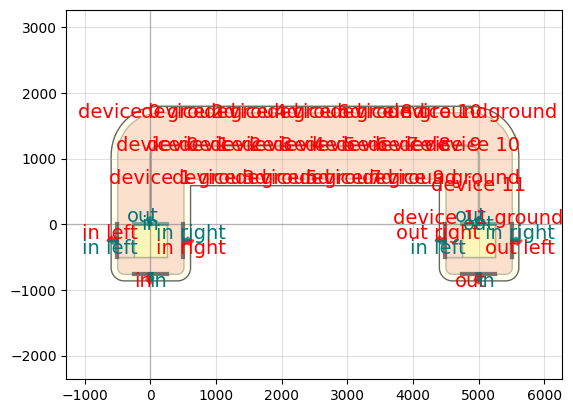

In [110]:
feedline_bot = Feedline()

feedline_points = [(0, 0), (0, 1200), (5000, 1200), (5000, 0)]
# device_points = [(x, 1200) for x in np.linspace(start=100, stop=4900, num=9)]

device_points = [(x, 1200) for x in np.linspace(start=100, stop=4900, num=11)] + [(5000, 600)]
device_orientations = [90, -90, 90, -90, 90, -90, 90, -90, 90, -90, 90] + [0]
ground_points = [(device_point[0], device_point[1] + (505*(-1)**i)) for i, device_point in enumerate(device_points)] + [(5000, 105)]
    
#feedline_bot.generate_feedline(FeedlineParams(feedline_points=feedline_points, device_points=device_points))

feedline_bot.generate_feedline(FeedlineParams(feedline_points=feedline_points, 
                                              device_points=device_points, 
                                              device_ground_points=ground_points,
                                              device_orientations=device_orientations))
qp(feedline_bot.device)

In [111]:
def alternate_split_merge(arr):
    # Step 1: Sort the list
    arr.sort()
    
    # Step 2: Find the middle index to split the list
    mid = len(arr) // 2 + 1
    
    # Step 3: Split the list into two halves
    lower_half = arr[:mid]
    upper_half = arr[mid:]
    
    # Step 4: Create a new list by alternating entries from both halves
    result = []
    i, j = 0, 0
    
    # Alternate between the lower and upper halves
    while i < len(lower_half) and j < len(upper_half):
        result.append(lower_half[i])
        result.append(upper_half[j])
        i += 1
        j += 1
    
    # If there are remaining elements in the lower half (odd number of elements)
    while j < len(lower_half):
        result.append(lower_half[j])
        j += 1
    
    return result


In [112]:
small_N_spacing = 0.03
decimal_places_N = 2
start_N = 15.3
stop_N = 15.7
num_N_groups = 5

Ns_squids = np.linspace(start_N + small_N_spacing, stop_N + small_N_spacing, num_N_groups)
Ns_squids_resistors = np.linspace(start_N, stop_N, num_N_groups)
Ns_spirals = np.array([start_N - 2*small_N_spacing])

Ns = np.concatenate((Ns_squids,
                     Ns_squids_resistors,
                     Ns_spirals))

print(Ns)

[15.33 15.43 15.53 15.63 15.73 15.3  15.4  15.5  15.6  15.7  15.24]


In [113]:
Ns = alternate_split_merge(Ns)
Ns = np.round(Ns, decimal_places_N)

print(Ns)

[15.24 15.53 15.3  15.6  15.33 15.63 15.4  15.7  15.43 15.73 15.5 ]


In [114]:
squid_params = SquidParams()
list_capa_params = [CapaParams(length_y=18)]*4 + [CapaParams(length_y=8.99)]
writefield_params = WritefieldParams()

In [115]:
list_res_params = []
list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=10, segment_length=25)) #5kOhm
list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=5, segment_length=25)) #10kOhm
#list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=2, segment_length=50)) #50kOhm
list_res_params.append(ResParams(num_segments=2, segment_length=25)) #100kOhm
#list_res_params.append(ResParams(num_segments=4, segment_length=50)) #400kOhm
list_res_params.append(ResParams(num_segments=10)) #1MOhm
list_res_params.append(ResParams(small_resistor=True, connectors=False, num_segments=20, segment_length=10)) #1kOhm
#list_res_params.append(ResParams(num_segments=20)) #2MOhm
#list_res_params.append(ResParams(num_segments=38, segment_length=65, spacing=2.1)) #5MOhm

In [116]:
capa_spacing = 1
shadow_shift = 0.3

def connect_to_resonator(element: Union[JJResistor, SquidResistor, JJSquidResistor, Squid, JJ],
                         element_port_name: str,
                         spiral: Spiral,
                         resonator_port_name: str,
                         capa_distance: float = capa_spacing + shadow_shift) -> None:

    resonator = spiral.device
    element_port: Port = element.device.ports[element_port_name]

    resonator_normal = resonator.ports[resonator_port_name].normal[1] - resonator.ports[resonator_port_name].normal[0]
    element_normal = element_port.normal[1] - element_port.normal[0]

    connector_parallel = [-resonator_normal[1], resonator_normal[0]]

    angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(resonator_normal,-element_normal), -1, 1)))%360

    if angle != 0:
        element.device.rotate(-angle)
        element.device.mirror()

    element.device.move(element_port, resonator.ports[resonator_port_name])
    element.device.move(capa_distance * resonator_normal)
    element.device.movex(origin=element_port.x, destination=resonator.ports['out'].x)
    element.device.movex(element_port.width/2)

In [117]:
squid_devices: list[QRCSJDevice] = []

for N, res_params, capa_params in zip(Ns_squids, list_res_params, list_capa_params):
    squid_device = QRCSJDevice()

    capa_params = copy.copy(capa_params)
    capa_params.no_resistor = True

    squid_device.assembled_device = Device('Squid Device')   
    

    squid_devices.append(squid_device)

    squid_resistor = SquidResistor()
    squid_resistor.generate_squid_resistor(res_params, squid_params, capa_params, writefield_params)
    if np.round(N, decimal_places_N) == 15.53 or np.round(N, decimal_places_N) == 15.63 or np.round(N, decimal_places_N) == 15.73:
        squid_resistor.device.mirror()

    spiral = Spiral()
    spiral.generate_spiral(SpiralParams(N=N, connector_shift=pg.extract(squid_resistor.device, layers=[default_ls['ebeam']]).ysize/2))
    
    squid_device.spiral = spiral
    spiral_ref = squid_device.assembled_device << spiral.device
    squid_device.assembled_device.add_port(spiral_ref.ports['in'])
    squid_device.assembled_device.add_port(spiral_ref.ports['out'])


    if np.round(N, decimal_places_N) == np.round(stop_N + small_N_spacing, decimal_places_N):
        connect_to_resonator(squid_resistor, 'capa bot', spiral, 'capa left')
    else:
        connect_to_resonator(squid_resistor, 'capa bot', spiral, 'capa right')
    squid_resistor.device.remove(squid_resistor.shunt_resistor)

    squid_device.assembled_device << squid_resistor.device
    squid_device.assembled_device.add_port(name='capa out', port=squid_resistor.device.ports['capa top'])
    squid_device.qubit = squid_resistor
    

squid_resistor_devices: list[QRCSJDevice] = []


for N, res_params, capa_params in zip(Ns_squids_resistors, list_res_params, list_capa_params):
    squid_resistor_device = QRCSJDevice()

    squid_resistor_device.assembled_device = Device('Squid Resistor Device')

    squid_resistor_devices.append(squid_resistor_device)

    squid_resistor = SquidResistor()
    squid_resistor.generate_squid_resistor(res_params, squid_params, capa_params, writefield_params)
    if np.round(N, decimal_places_N) == 15.6 or np.round(N, decimal_places_N) == 15.7 :
        squid_resistor.device.mirror()
    

    spiral = Spiral()
    spiral.generate_spiral(SpiralParams(N=N, connector_shift=pg.extract(squid_resistor.device, layers=[default_ls['ebeam']]).ysize/2))
    
    squid_resistor_device.spiral = spiral
    spiral_ref = squid_resistor_device.assembled_device << spiral.device
    squid_resistor_device.assembled_device.add_port(spiral_ref.ports['in'])
    squid_resistor_device.assembled_device.add_port(spiral_ref.ports['out'])

    if np.round(N, decimal_places_N) == 15.3 or np.round(N, decimal_places_N) == 15.4 or np.round(N, decimal_places_N) == 15.5:
        connect_to_resonator(squid_resistor, 'capa top', spiral, 'capa right')
        squid_resistor_device.assembled_device.add_port(name='capa out', port=squid_resistor.device.ports['capa bot'])
    else:
        connect_to_resonator(squid_resistor, 'capa bot', spiral, 'capa right')
        squid_resistor_device.assembled_device.add_port(name='capa out', port=squid_resistor.device.ports['capa top'])

    squid_resistor_device.assembled_device << squid_resistor.device
    
    squid_resistor_device.qubit = squid_resistor

 



spiral_devices: list[QRCSJDevice] = []

for N in Ns_spirals:
    spiral_device = QRCSJDevice()
    spiral_device.assembled_device = Device('Spiral Device')

    spiral = Spiral()
    spiral.generate_spiral(SpiralParams(N=N, connector_length=0))
    
    spiral_device.spiral = spiral
    spiral_ref = spiral_device.assembled_device << spiral.device
    spiral_device.assembled_device.add_port(spiral_ref.ports['in'])
    spiral_device.assembled_device.add_port(spiral_ref.ports['out'])

    spiral_devices.append(spiral_device)

    

all_devices = squid_devices + squid_resistor_devices + spiral_devices

failed offsetting undercut
failed offsetting undercut
failed offsetting undercut
failed offsetting undercut
failed offsetting undercut


In [118]:
def alternate_split_merge_indices(arr):
    # Step 1: Get the sorted indices of the array
    sorted_indices = np.argsort(arr)
    
    # Step 2: Find the middle index to split the list
    mid = len(sorted_indices) // 2 + 1
    
    # Step 3: Split the sorted indices into two halves
    lower_half = sorted_indices[:mid]
    upper_half = sorted_indices[mid:]
    
    # Step 4: Create a new list by alternating entries from both halves
    result = []
    i, j = 0, 0
    
    # Alternate between the lower and upper halves
    while i < len(lower_half) and j < len(upper_half):
        result.append(lower_half[i])
        result.append(upper_half[j])
        i += 1
        j += 1
    
    # If there are remaining elements in the lower half (odd number of elements)
    while i < len(lower_half):
        result.append(lower_half[i])
        i += 1
    
    return result

In [119]:
sorted_indices = alternate_split_merge_indices([dev.spiral.spiral_params.N for dev in all_devices])

all_devices: list[QRCSJDevice] = [all_devices[index] for index in sorted_indices]

In [120]:
def add_ground_capacitor(reference: DeviceReference,
                         port_name: str,
                         feedline: Feedline,
                         length: float = 500,
                         width: float = 3,
                         capa_distance: float = capa_spacing + shadow_shift,
                         layer: Layer = default_ls['routing']) -> None:
    
    element_port: Port = reference.ports[port_name]
    element_normal = element_port.normal[1] - element_port.normal[0]

    ground_capacitor = Device('Ground capacitor')
    ground_capacitor << pg.rectangle(size=(width, length), layer=layer)

    if length > 0:
        ground_capacitor.add_port(name='capa in', 
                              midpoint=(0, length - element_port.width/2),
                              width=element_port.width,
                              orientation=180)
    else:
         ground_capacitor.add_port(name='capa in', 
                              midpoint=(0, length + element_port.width/2),
                              width=element_port.width,
                              orientation=180)
    
    
    ground_capacitor_ref = feedline.device << ground_capacitor
    ground_capacitor_ref.connect('capa in', element_port)
    ground_capacitor_ref.move(element_normal * capa_distance)

    



# def add_ground_capacitor(element: DeviceReference,
#                          element_port_name: str, 
#                          feedline: Feedline,
#                          device_number: int, 
#                          capa_length: float,
#                          capa_distance: float = capa_spacing + shadow_shift,
#                          width = 3,
#                          overlap = 20) -> None:

#     element_port: Port = element.ports[element_port_name]

#     distance_to_ground = np.abs(- element.ports['out'].y + feedline.device.ports[f'device {device_number} ground'].y)

#     ground_capa = feedline.device << pg.compass(size=(width, distance_to_ground + overlap + capa_length), layer=default_ls['routing'])

#     ground_capa.connect(ground_capa['W'], element_port)

#     # ground_normal = feedline.device.ports[f'device {device_number} ground'].normal[1] - feedline.device.ports[f'device {device_number} ground'].normal[0]
#     # capa_normal = ground_capa.pad.ports['ground'].normal[1] - ground_capa.pad.ports['ground'].normal[0]
    
#     # angle = np.round((360/(2*np.pi)) * np.arccos(np.clip(np.dot(ground_normal, capa_normal), -1, 1)))%360

#     # if angle != 0:
#     #     ground_capa.device.rotate(angle)

#     # ground_capa.device.move(ground_capa.plate.ports['capa'], element_port)
#     # ground_capa.device.move(-capa_distance * ground_normal)

#     # feedline.device << ground_capa.device

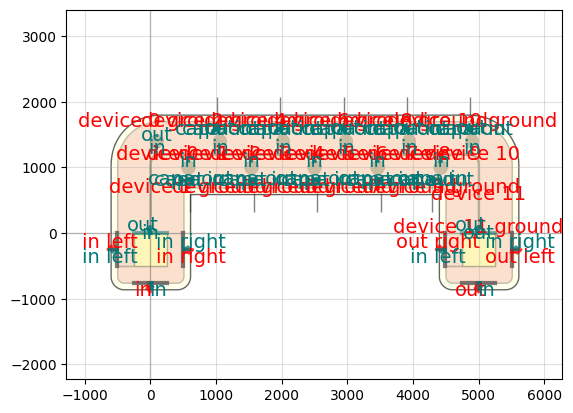

In [121]:
coupling_distance = 100
all_device_refs: list[DeviceReference] = []


for i,device in enumerate(all_devices):
    all_device_refs.append(feedline_bot.device << device.assembled_device)

    all_device_refs[-1].connect('in', feedline_bot.device.ports[f'device {i}'])

    normal = all_device_refs[-1].ports['in'].normal[0] - all_device_refs[-1].ports['in'].normal[1]
    all_device_refs[-1].move(normal * coupling_distance)

    if device.qubit != None:
        if i == len(all_devices) - 2:
            add_ground_capacitor(all_device_refs[-1], 'capa out', feedline_bot, length=-500)
        else:
            add_ground_capacitor(all_device_refs[-1], 'capa out', feedline_bot)

    device.number = i
    device.id = f'Bot {i}'
    device.position = all_device_refs[-1].center

qp(feedline_bot.device)

In [122]:
# Extra spiral

spiral_device = QRCSJDevice()
spiral_device.assembled_device = Device('Spiral Device')

spiral = Spiral()
spiral.generate_spiral(SpiralParams(N=stop_N + 3*small_N_spacing, connector_length=0))

spiral_device.spiral = spiral
spiral_ref = spiral_device.assembled_device << spiral.device
spiral_device.assembled_device.add_port(spiral_ref.ports['in'])
spiral_device.assembled_device.add_port(spiral_ref.ports['out'])

spiral_devices.append(spiral_device)
all_devices.append(spiral_device)

all_device_refs.append(feedline_bot.device << spiral_device.assembled_device)

i=len(device_points) -1
all_device_refs[-1].connect('in', feedline_bot.device.ports[f'device {i}'])

normal = all_device_refs[-1].ports['in'].normal[0] - all_device_refs[-1].ports['in'].normal[1]
all_device_refs[-1].move(normal * coupling_distance)

device.number = i
device.id = f'Bot {i}'
device.position = all_device_refs[-1].center

In [123]:
for dev in all_devices:
    print(dev.spiral.spiral_params.N)
    print(dev.spiral.get_resonance_frequency())

15.24
8978577207.280495
15.53
8620993488.842154
15.3
8903009561.90187
15.6
8537503992.74585
15.33
8865540927.824318
15.629999999999999
8502048358.808748
15.4
8778920550.041893
15.7
8420067832.713671
15.43
8742139467.395813
15.729999999999999
8385251088.173059
15.5
8657103739.82876
15.79
8316182250.03974


In [124]:
feedline_bot.correct_optical_layer()

In [125]:
feedline_bot.device.write_gds('Feedline_Bot.gds')

with open('feedline_bot.pkl', 'wb') as f:
    pickle.dump(feedline_bot, f)

In [126]:
feedline_bot.device.mirror(p1=(-1, 0), p2=(1,0))
#feedline_bot.device.mirror()

feedline_bot.device.write_gds('Feedline_Top.gds')

with open('feedline_top.pkl', 'wb') as f:
    pickle.dump(feedline_bot, f)